En este notebook se desarrollan los gráficos que se usarán en la parte de resultados del TFM

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from src.datasets import daocensus, daocensus_text, to_microsoft
from src import paths

In [2]:
ORG_NAME = 'Decentraland'
ORG_PLATFORM = 'snapshot'
USE_ORG_NAMES: bool = False
CUTOFF_DATE_STR: str = None
LAST_SPLITS = ... # Wont be used

SPLITS_FREQ = 'W-THU'
SPLITS_NORMALIZE: bool = True

In [3]:
# Parameters
ORG_NAME = "MetaCartel - MetaCartel Ventures"
ORG_PLATFORM = ["daohaus", "snapshot"]
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-08 10:00"
CUTOFF_DATE_STR = "2020-11-06"


In [4]:
CUTOFF_DATE = dt.datetime.fromisoformat(CUTOFF_DATE_STR) if CUTOFF_DATE_STR else None

# Exploración de datos de Decentraland

In [5]:
# dfptext = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, ORG_PLATFORM)
# dfv['voter'] = dfv['voter'].astype('str')
# dfp = dfp.merge(dfptext, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')
# dfp = dfp.set_index('id')
dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES, cutoff_date=CUTOFF_DATE)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

,platform,name,id,proposal,deployment,platform_vote,voter,date,choice,weight
0,daohaus,MetaCartel - MetaCartel Ventures,a7a47c63-4c4d-58ae-88ee-f6ce6946d088,b23fab43-3b08-5638-b13d-0e286cadb04b,b5c669ac-488c-5b91-82cc-e98add7af0b7,0x0372f3696fa7dc99801f435fd6737e57818239f2-mem...,0x0eabffd8ce94ab2387fc44ba32642af0c58af433,2020-04-01 03:11:46,1,NaN
1,daohaus,MetaCartel - MetaCartel Ventures,f1a74998-e2f3-55f0-964e-f3a8aa56c5c5,18f8c9fd-9796-5802-ab78-b449c65ffb50,b5c669ac-488c-5b91-82cc-e98add7af0b7,0x0372f3696fa7dc99801f435fd6737e57818239f2-mem...,0x0eabffd8ce94ab2387fc44ba32642af0c58af433,2020-06-17 03:08:43,1,NaN
2,daohaus,MetaCartel - MetaCartel Ventures,ae6f03c5-adb5-50d5-849b-761a928ec3f6,2a062f74-c7cb-5625-b8ba-537b23ae5318,b5c669ac-488c-5b91-82cc-e98add7af0b7,0x0372f3696fa7dc99801f435fd6737e57818239f2-mem...,0x0eabffd8ce94ab2387fc44ba32642af0c58af433,2019-07-25 20:06:53,1,NaN
3,daohaus,MetaCartel - MetaCartel Ventures,c00e1243-5304-521c-8c98-eae0c80619b4,3eff52ec-93aa-5c41-9ff2-3a18d278d138,b5c669ac-488c-5b91-82cc-e98add7af0b7,0x0372f3696fa7dc99801f435fd6737e57818239f2-mem...,0x0eabffd8ce94ab2387fc44ba32642af0c58af433,2019-07-30 18:13:46,1,NaN
4,daohaus,MetaCartel - MetaCartel Ventures,98963761-315a-530b-9210-aaae317182b1,b21a24a0-1a16-55a1-8c0e-c97ed7cf8e69,b5c669ac-488c-5b91-82cc-e98add7af0b7,0x0372f3696fa7dc99801f435fd6737e57818239f2-mem...,0x0eabffd8ce94ab2387fc44ba32642af0c58af433,2019-08-06 18:25:25,1,NaN
...,...,...,...,...,...,...,...,...,...,...
1100,daohaus,MetaCartel - MetaCartel Ventures,b6e5b58c-3f16-51ec-b4a7-4f7be375709a,ed418dda-7d6f-5e96-abfc-be7e834082b6,899cc74b-f242-5fd2-a270-763436927977,0x4570b4faf71e23942b8b9f934b47ccedf7540162-mem...,0xfdc6a17917115498a3ed417d4a89224685f26ea3,2020-10-13 16:30:12,1,769.0
1101,daohaus,MetaCartel - MetaCartel Ventures,646da2cf-29ba-5257-9396-0dba4ed0310f,b1ee7c7d-25d9-5fe4-90d3-7cac48beadda,899cc74b-f242-5fd2-a270-763436927977,0x4570b4faf71e23942b8b9f934b47ccedf7540162-mem...,0xfdc6a17917115498a3ed417d4a89224685f26ea3,2020-10-20 03:11:35,1,769.0
1102,daohaus,MetaCartel - MetaCartel Ventures,f9760482-0a78-55d2-8ac0-750a29b7670a,ea49447a-f0a2-5bba-8ad5-45df68670c67,899cc74b-f242-5fd2-a270-763436927977,0x4570b4faf71e23942b8b9f934b47ccedf7540162-mem...,0xfdc6a17917115498a3ed417d4a89224685f26ea3,2020-10-20 03:11:52,1,769.0
1103,daohaus,MetaCartel - MetaCartel Ventures,44f10cb1-5a02-5602-b979-d493de67b502,0dc04c0d-be1b-5b91-8454-d465ac413f96,899cc74b-f242-5fd2-a270-763436927977,0x4570b4faf71e23942b8b9f934b47ccedf7540162-mem...,0xfdc6a17917115498a3ed417d4a89224685f26ea3,2020-10-20 03:11:52,1,769.0


Warning, removing 1105 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1105 entries, 0 to 1104
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   platform       1105 non-null   object        
 1   name           1105 non-null   object        
 2   id             1105 non-null   object        
 3   proposal       1105 non-null   category      
 4   deployment     1105 non-null   object        
 5   platform_vote  1105 non-null   object        
 6   voter          1105 non-null   category      
 7   date           1105 non-null   datetime64[ns]
 8   choice         1105 non-null   object        
 9   weight         686 non-null    float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 84.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 373 entries, 2a062f74-c7cb-5625-b8ba-537b23ae5318 to 411dc063-5cd7-5de3-ac9a-5c9dba3f721a

## Cuantas propuestas tenemos para entrenar en el dataset

In [6]:
from src.model_selection import timeFreqSplitCurrent, filter_current
from collections import defaultdict

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['t'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('t')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
sdf = sdf_all.tail(10)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

t
2020-08-20     764
2020-08-27     793
2020-09-03     816
2020-09-10     834
2020-09-17     859
2020-09-24     902
2020-10-01     952
2020-10-08     973
2020-10-15    1003
2020-10-22    1050
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
t,,,,,,,,,
2020-W34,27,46,13,1.70,3.54,8,4,0.30,2.00
2020-W35,34,59,13,1.74,4.54,3,3,0.09,1.00
2020-W36,37,68,18,1.84,3.78,8,7,0.22,1.14
2020-W37,16,39,18,2.44,2.17,7,3,0.44,2.33
2020-W38,22,32,12,1.45,2.67,13,6,0.59,2.17
2020-W39,33,63,18,1.91,3.50,43,20,1.30,2.15
2020-W40,24,88,30,3.67,2.93,1,1,0.04,1.00
2020-W41,18,53,24,2.94,2.21,6,3,0.33,2.00
2020-W42,17,51,23,3.00,2.22,9,9,0.53,1.00


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
t &  &  &  &  &  &  &  &  &  \\
2020-W34 & 27 & 46 & 13 & 1.70 & 3.54 & 8 & 4 & 0.30 & 2.00 \\
2020-W35 & 34 & 59 & 13 & 1.74 & 4.54 & 3 & 3 & 0.09 & 1.00 \\
2020-W36 & 37 & 68 & 18 & 1.84 & 3.78 & 8 & 7 & 0.22 & 1.14 \\
2020-W37 & 16 & 39 & 18 & 2.44 & 2.17 & 7 & 3 & 0.44 & 2.33 \\
2020-W38 & 22 & 32 & 12 & 1.45 & 2.67 & 13 & 6 & 0.59 & 2.17 \\
2020-W39 & 33 & 63 & 18 & 1.91 & 3.50 & 43 & 20 & 1.30 & 2.15 \\
2020-W40 & 24 & 88 & 30 & 3.67 & 2.93 & 1 & 1 & 0.04 & 1.00 \\
2020-W41 & 18 & 53 & 24 & 2.94 & 2.21 & 6 & 3 & 0.33 & 2.00 \\
2020-W42 & 17 & 51 & 23 & 3.00 & 2.22 & 9 & 9 & 0.53 & 1.00 \\
2020-W43 & 11 & 71 & 27 & 6.45 & 2.63 & 7 & 5 & 0.64 & 1.40 \\
\end{tabular}



In [9]:
sdf.describe()

,open proposals,proposals in train,votes in train,votes in open proposals (train),users in open proposals (train),votes in test,users in train,users in test,vpp in open proposals (train),vpu in open proposals (train),vpp test,vpu test
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000
mean,23.90000,326.700000,894.600000,57.000000,19.600000,10.500000,84.500000,6.10000,2.714363,3.017672,0.447296,1.619286
std,8.69802,28.775182,96.547283,16.465452,6.203941,11.872003,6.786424,5.40473,1.494097,0.795474,0.361807,0.558435
min,11.00000,281.000000,764.000000,32.000000,12.000000,1.000000,76.000000,1.00000,1.454545,2.166667,0.041667,1.000000
25%,17.25000,305.750000,820.500000,47.250000,14.250000,6.250000,78.750000,3.00000,1.760930,2.320451,0.236236,1.035714
50%,23.00000,329.000000,880.500000,56.000000,18.000000,7.500000,84.000000,4.50000,2.173295,2.800000,0.385417,1.700000
75%,31.50000,352.500000,967.750000,66.750000,23.750000,8.750000,88.000000,6.75000,2.986111,3.528846,0.575535,2.112500
max,37.00000,363.000000,1050.000000,88.000000,30.000000,43.000000,96.000000,20.00000,6.454545,4.538462,1.303030,2.333333


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '2020-W34'),
  Text(1, 0, '2020-W35'),
  Text(2, 0, '2020-W36'),
  Text(3, 0, '2020-W37'),
  Text(4, 0, '2020-W38'),
  Text(5, 0, '2020-W39'),
  Text(6, 0, '2020-W40'),
  Text(7, 0, '2020-W41'),
  Text(8, 0, '2020-W42'),
  Text(9, 0, '2020-W43')])

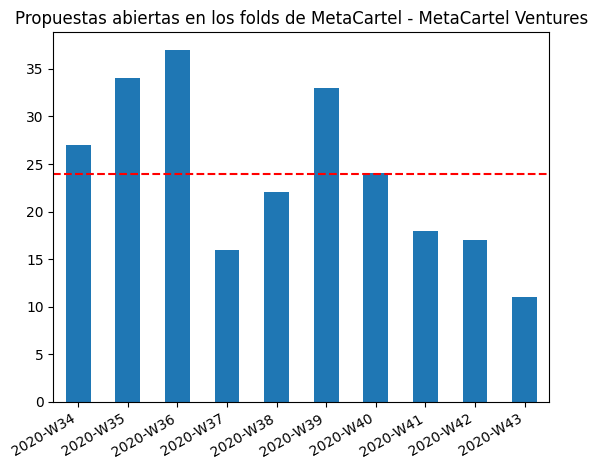

In [10]:
ax = sdf[['open proposals']].plot.bar(legend=False, xlabel='')
plt.axhline(sdf['open proposals'].mean(), c='red', linestyle='--')
ax.set_title(f'Propuestas abiertas en los folds de {ORG_NAME}')
ax.set_xticklabels(sdf.index.strftime('%G-W%V'))
plt.xticks(rotation=30, ha='right')
# TODO: Pintar horizonte con la media

<Axes: xlabel='t'>

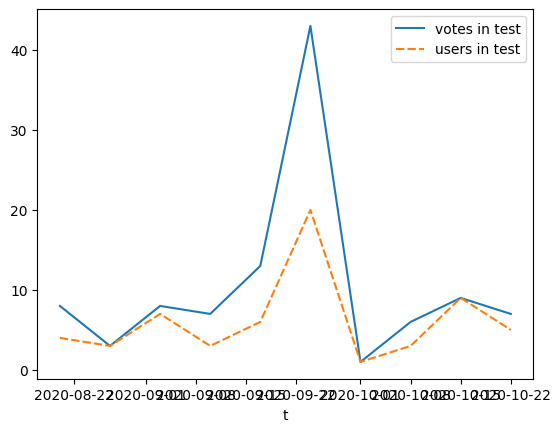

In [11]:
sns.lineplot(sdf[[
    # 'users in train (filtered)', 'votes in train (filtered)', 
    'votes in test', 'users in test',
]])

### Numero de propuestas relevantes
Además del número de propuestas abiertas, queremos saber cual es la _precision@k_ máxima, para ello es necesario saber no sólo el número de propuestas abiertas, si no en cuantas de esas propuestas votaron los usuarios. En términos de IR, necesitamos saber cual es el número de documentos relevantes, que seguramente sea menor que el número de documentos recuperados.

In [12]:
sdf['vpu in test'] = sdf['votes in test'] / sdf['users in test']
sdf

/tmp/ipykernel_3525587/710207913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['vpu in test'] = sdf['votes in test'] / sdf['users in test']


,open proposals,proposals in train,votes in train,votes in open proposals (train),users in open proposals (train),votes in test,users in train,users in test,vpp in open proposals (train),vpu in open proposals (train),vpp test,vpu test,vpu in test
t,,,,,,,,,,,,,
2020-08-20,27,281,764,46,13,8,76,4,1.703704,3.538462,0.296296,2.000000,2.000000
2020-08-27,34,296,793,59,13,3,77,3,1.735294,4.538462,0.088235,1.000000,1.000000
2020-09-03,37,305,816,68,18,8,78,7,1.837838,3.777778,0.216216,1.142857,1.142857
2020-09-10,16,308,834,39,18,7,81,3,2.437500,2.166667,0.437500,2.333333,2.333333
2020-09-17,22,319,859,32,12,13,83,6,1.454545,2.666667,0.590909,2.166667,2.166667
2020-09-24,33,339,902,63,18,43,85,20,1.909091,3.500000,1.303030,2.150000,2.150000
2020-10-01,24,342,952,88,30,1,88,1,3.666667,2.933333,0.041667,1.000000,1.000000
2020-10-08,18,356,973,53,24,6,88,3,2.944444,2.208333,0.333333,2.000000,2.000000
2020-10-15,17,358,1003,51,23,9,93,9,3.000000,2.217391,0.529412,1.000000,1.000000


# Recomendador GNN

In [13]:
dfh = pd.read_csv(paths.hybrid_results(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE))
dfg = dfh[dfh['model'] == 'gnn'].reset_index(drop=True)
dfg

,t,merge,map@10,map@5,ndcg@10,ndcg@5,precision@10,precision@5,recall@10,recall@5,model
0,2020-08-20,-,0.458333,0.458333,0.532111,0.532111,0.150000,0.300000,0.666667,0.666667,gnn
1,2020-08-27,-,0.083333,0.083333,0.143559,0.143559,0.033333,0.066667,0.333333,0.333333,gnn
2,2020-09-03,-,0.030159,0.014286,0.060253,0.033885,0.028571,0.028571,0.142857,0.071429,gnn
3,2020-09-10,-,0.329960,0.193056,0.497435,0.296596,0.233333,0.266667,1.000000,0.500000,gnn
4,2020-09-17,-,0.118576,0.029861,0.205091,0.074476,0.150000,0.100000,0.479167,0.062500,gnn
5,2020-09-24,-,0.166821,0.144083,0.220840,0.181662,0.065000,0.090000,0.353333,0.255833,gnn
6,2020-10-01,-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,gnn
7,2020-10-08,-,0.333333,0.277778,0.483982,0.366736,0.133333,0.133333,0.722222,0.444444,gnn
8,2020-10-15,-,0.258333,0.244444,0.300258,0.265206,0.044444,0.066667,0.444444,0.333333,gnn
9,2020-10-22,-,0.477778,0.444444,0.618134,0.584702,0.140000,0.240000,1.000000,0.933333,gnn


# Recomendador Híbrido

In [14]:
from src import baseline

# dfm_baseline = pd.read_csv(f'./data/baseline/mp-freq-{ORG_NAME}-{SPLITS_FREQ}.csv')
dfm_baseline = baseline.read_metrics_baseline(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date = CUTOFF_DATE)
dfm_baseline['model'] = 'mp'
dfm_all = pd.read_csv(paths.hybrid_results(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE)).set_index('t')
dfm_all = pd.concat((dfm_all, dfm_baseline))
dfm_all

,merge,map@10,map@5,ndcg@10,ndcg@5,precision@10,precision@5,recall@10,recall@5,model,precision@15,ndcg@15,map@15,recall@15
t,,,,,,,,,,,,,,
2020-08-20,avg,0.276389,0.308333,0.387792,0.407459,0.150000,0.250000,0.666667,0.583333,hybrid,NaN,NaN,NaN,NaN
2020-08-27,avg,0.333333,0.333333,0.333333,0.333333,0.033333,0.066667,0.333333,0.333333,hybrid,NaN,NaN,NaN,NaN
2020-09-03,avg,0.064286,0.014286,0.089150,0.033885,0.028571,0.028571,0.142857,0.071429,hybrid,NaN,NaN,NaN,NaN
2020-09-10,avg,0.393452,0.250000,0.556790,0.334509,0.233333,0.133333,1.000000,0.250000,hybrid,NaN,NaN,NaN,NaN
2020-09-17,avg,0.588633,0.223958,0.652267,0.326846,0.200000,0.166667,0.833333,0.395833,hybrid,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-07 23:31:13,NaN,0.312963,0.312963,0.452293,0.452293,0.166667,0.333333,0.833333,0.833333,mp,0.111111,0.452293,0.312963,0.833333
2020-10-14 20:47:38,NaN,0.138889,0.138889,0.158964,0.158964,0.022222,0.044444,0.222222,0.222222,mp,0.014815,0.158964,0.138889,0.222222
2020-10-21 23:11:51,NaN,0.434444,0.434444,0.576308,0.576308,0.140000,0.280000,1.000000,1.000000,mp,0.093333,0.576308,0.434444,1.000000
